In [1]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import sklearn
import scipy as sp
import statsmodels as sm
import seaborn as sns
import xgboost as xgb
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation


def plot_ts(ts_list):
    
    plt.figure(figsize=[9,5])

    gs = gridspec.GridSpec(1, 2, width_ratios=[5, 2])
    ax1 = plt.subplot(gs[0])
    for i, ts in enumerate(ts_list):
        ax1.plot(ts, label='ts_'+str(i+1))
    ax1.set_ylim([0,200])
    ax1.set_xlim([0,365])
    ax1.legend()
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Count (e.g. clicks, views)')

    ax2 = plt.subplot(gs[1])
    for i, ts in enumerate(ts_list):
        sns.kdeplot(ts, ax=ax2,  clip=[50,150],  label='ts_'+str(i+1), shade=True)
    ax2.legend()
    ax2.set_xlabel('Count')
    ax2.set_ylabel('Density')
    plt.tight_layout()
    plt.show()
    
print(xgb.__version__)
np.__version__

Using TensorFlow backend.


0.82


'1.14.3'

In [2]:
from keras import backend as K
K.device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6372392931332510434]

## Tree Ensembles and Neural Networks

| **Random Forest**   | **Artificial Neural Network** |
|------|------|
|https://upload.wikimedia.org/wikipedia/commons/7/76/Random_forest_diagram_complete.png| https://commons.wikimedia.org/wiki/File:MultiLayerNeuralNetwork_english.png |

### ML Naive Expectations

In [3]:
n_feats = 8
df_len = 5000
np.random.seed(13)
df = pd.DataFrame(
    data=np.random.randn(df_len, n_feats), columns=['feature_' + str(i) for i in range(n_feats)])
target = pd.Series(data=np.random.choice([0,1], size=df_len), name='target')
df = df.add(target, axis = 0)
df = df.add((target-1), axis = 0)
df['target'] = target
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,target
0,0.287609,1.753766,0.955497,1.451812,2.345102,1.532338,2.350188,1.861211,1
1,0.478686,-2.045377,-1.788989,-2.261606,-0.437153,-1.243326,-0.086259,-0.682649,0
2,-0.872697,1.150383,-0.393711,-1.026772,-1.984161,0.190705,-0.047169,-2.087182,0
3,0.854789,1.237858,-0.639093,0.721865,2.399238,-0.615108,1.490872,2.892742,1
4,0.379020,0.546248,1.217452,1.514329,1.397241,-0.512845,0.235966,1.101270,1


In [4]:
df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,target
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,-0.007064,0.053871,0.021548,0.030483,0.043668,0.022612,0.047539,0.036793,0.513600
std,1.394695,1.391242,1.419785,1.409541,1.427575,1.409915,1.397664,1.393862,0.499865
min,-4.563094,-4.425661,-4.768564,-4.023676,-4.097481,-4.602779,-4.609567,-4.530686,0.000000
25%,-1.027308,-0.981864,-1.026704,-1.004090,-1.018777,-1.017634,-0.983229,-1.012082,0.000000
50%,-0.024143,0.062405,0.030949,0.037676,0.044159,0.061267,0.051267,0.077965,1.000000
75%,1.001228,1.075554,1.076434,1.066300,1.132340,1.081729,1.092292,1.059815,1.000000
max,4.640802,4.200125,5.442371,4.565342,4.373126,4.044063,4.538423,4.670476,1.000000


<IPython.core.display.Javascript object>


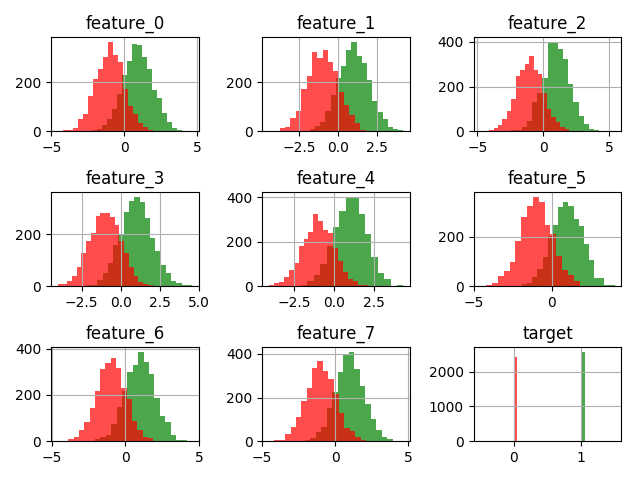

In [5]:
ax1 = df[df.target==1].hist(bins=20, alpha=0.7, color='green')
df[df.target==0].hist(ax=ax1, bins=20, alpha=0.7, color='red')
plt.tight_layout()
plt.show()

In [6]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    df.drop('target', axis = 1), df.target, test_size=0.3, random_state=13)

In [7]:
xgb_clf = xgb.XGBClassifier(n_estimators=30, nthread=8, tree_method='hist', max_bin=64, seed=13)
xgb_clf.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=10,
            eval_metric='error', verbose=False)
print("Validation Accuracy = {:.4f}".format(1- xgb_clf.best_score))

[08:23:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Validation Accuracy = 0.9973


In [8]:
Y_train = keras.utils.np_utils.to_categorical(y_train, 2)
Y_test = keras.utils.np_utils.to_categorical(y_test, 2)

np.random.seed(13)
model = keras.models.Sequential()
model.add(Dense(4, input_shape=(len(X_train.columns),)))
model.add(Activation('relu')) 
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=0,
                    validation_data=(X_test, Y_test))

print("\nValidation Accuracy = {:.4f}".format(history.history['val_acc'][-1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 46
Trainable params: 46
Non-trainable params: 0
_________________________________________________________________

Validation Accuracy = 0.9973


### Reality

### Example business use-cases:
* Churn
* Ad targeting
* Marketing campaigns
* Recommenders

# Feature Extraction

# Time Series

<IPython.core.display.Javascript object>


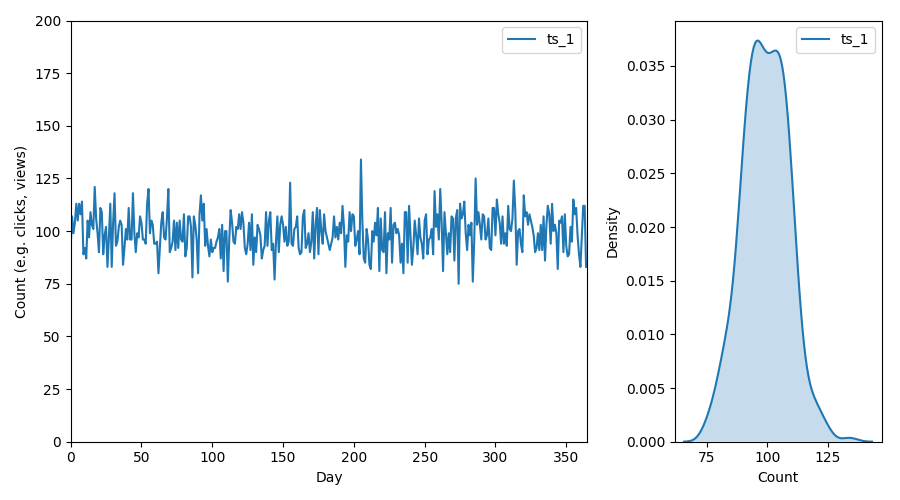

In [9]:
ts_len = 365
np.random.seed(13)
ts_1 = np.random.normal(loc=100.0, scale=10, size = ts_len).astype('int')

plot_ts([ts_1])

mean_1 = 99.33
mean_2 = 74.21
mean_3 = 124.16


<IPython.core.display.Javascript object>


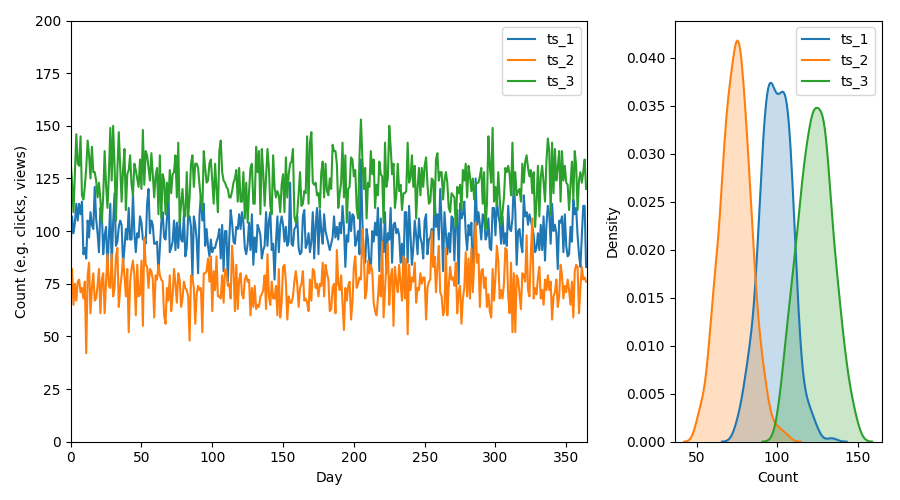

In [10]:
np.random.seed(13)
ts_1 = np.random.normal(loc=100.0, scale=10, size = ts_len).astype('int')
ts_2 = np.random.normal(loc=75.0, scale=10, size = ts_len).astype('int')
ts_3 = np.random.normal(loc=125.0, scale=10, size = ts_len).astype('int')

ts_list = [ts_1, ts_2, ts_3]
for i, ts in enumerate(ts_list):
    print("mean_{0} = {1:.2f}".format(i+1, np.mean(ts)))
plot_ts(ts_list)

mean_1 = 99.18	 std_1 = 18.84	 min_1 = 50.00	 max_1 = 168.00
mean_2 = 99.35	 std_2 = 4.87	 min_2 = 83.00	 max_2 = 115.00


<IPython.core.display.Javascript object>


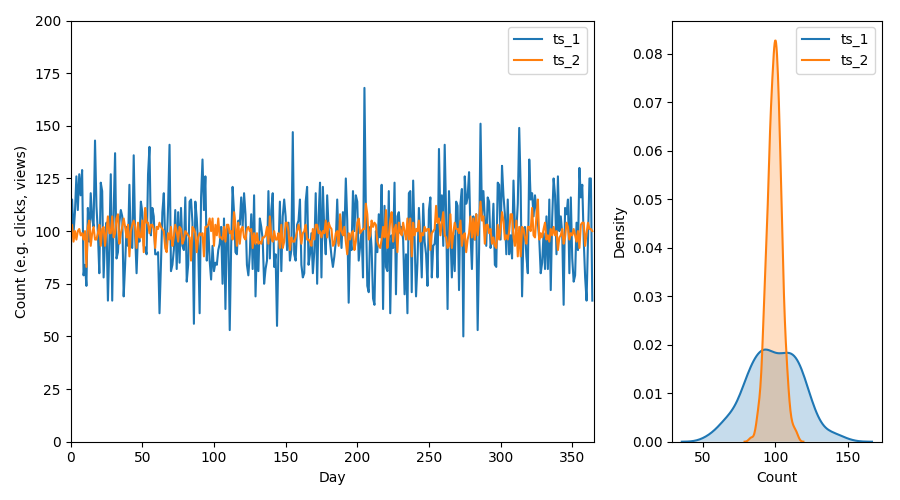

In [11]:
np.random.seed(13)
ts_1 = np.random.normal(loc=100.0, scale=20, size = ts_len).astype('int')
ts_2 = np.random.normal(loc=100.0, scale=5, size = ts_len).astype('int')

ts_list = [ts_1, ts_2]
for i, ts in enumerate(ts_list):
    print("mean_{0} = {1:.2f}\t std_{0} = {2:.2f}\t min_{0} = {3:.2f}\t max_{0} = {4:.2f}".format(
        i+1, np.mean(ts), np.std(ts), np.min(ts), np.max(ts)))
plot_ts(ts_list)

mean_1 = 97.76	 std_1 = 11.06	 skew_1 = -2.49	 kurt_1 = 12.48
mean_2 = 98.17	 std_2 = 10.63	 skew_2 = 0.04	 kurt_2 = 0.40


<IPython.core.display.Javascript object>


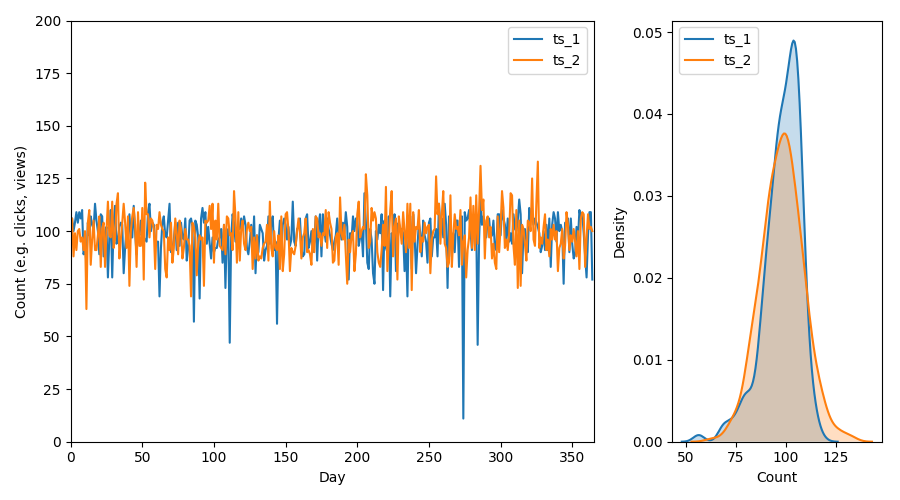

In [12]:
from scipy.stats import describe

np.random.seed(13)
ts_1 = (15*np.log2(np.random.normal(loc=104.0, scale=41, size = ts_len))).astype('int')
ts_2 = np.random.normal(loc=99, scale=11, size = ts_len).astype('int')

ts_list = [ts_1, ts_2]
for i, ts in enumerate(ts_list):
    print("mean_{0} = {1:.2f}\t std_{0} = {2:.2f}\t skew_{0} = {3:.2f}\t kurt_{0} = {4:.2f}".format(
        i+1, np.mean(ts), np.std(ts), describe(ts).skewness, describe(ts).kurtosis))
plot_ts(ts_list)

mean_1 = 98.64	 std_1 = 22.87	 skew_1 = -0.03	 kurt_1 = -0.69
mean_2 = 99.15	 std_2 = 26.40	 skew_2 = -0.08	 kurt_2 = -0.83
ts_1:	 p_1 = 48.6	 p_25 = 82.0	 p_50 = 98.0	 p_75 = 116.0	 p_99 = 144.0	
ts_2:	 p_1 = 44.3	 p_25 = 79.0	 p_50 = 100.0	 p_75 = 120.0	 p_99 = 149.7	


<IPython.core.display.Javascript object>


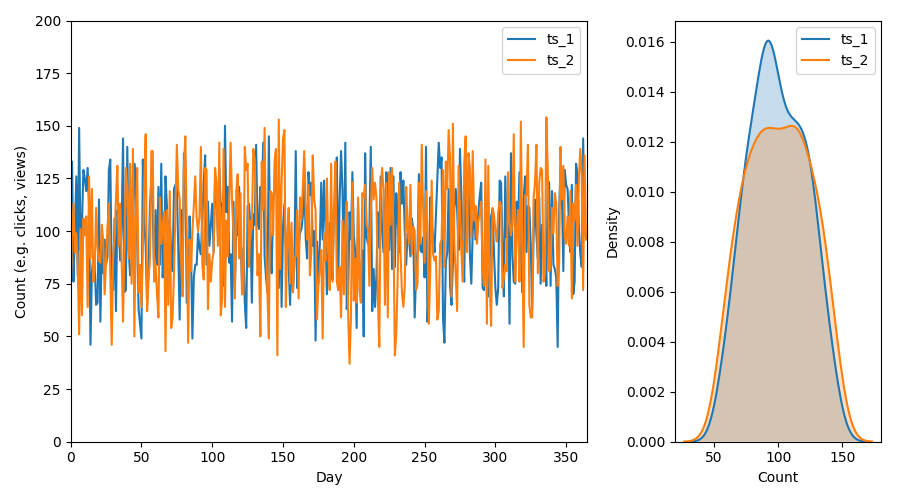

In [13]:
np.random.seed(13)
ts_1 = np.random.choice(np.arange(20,100), size = ts_len).astype('int') + \
    np.random.normal(loc=40.0, scale=10, size = ts_len).astype('int')
ts_2 = np.random.choice(np.arange(30,110), size = ts_len).astype('int')+ \
    np.random.normal(loc=30.0, scale=10, size = ts_len).astype('int')

ts_list = [ts_1, ts_2]
percentiles = [1,25,50,75,99]
for i, ts in enumerate(ts_list):
    print("mean_{0} = {1:.2f}\t std_{0} = {2:.2f}\t skew_{0} = {3:.2f}\t kurt_{0} = {4:.2f}".format(
        i+1, np.mean(ts), np.std(ts), describe(ts).skewness, describe(ts).kurtosis))
for i, ts in enumerate(ts_list):    
    print("ts_" + str(i+1) + ":\t", *["p_" + str(p) + " = " + str(np.round(perc,1)) +"\t"
            for p, perc in zip(percentiles, np.percentile(a=ts, q=percentiles))])
plot_ts(ts_list)

mean_1 = 100.18	 std_1 = 28.60	 skew_1 = 0.19	 kurt_1 = -0.46
mean_2 = 99.91	 std_2 = 27.72	 skew_2 = -0.04	 kurt_2 = -0.54
ts_1:	 p_1 = 39.3	 p_25 = 78.0	 p_50 = 98.0	 p_75 = 119.0	 p_99 = 164.1	
ts_2:	 p_1 = 37.3	 p_25 = 80.0	 p_50 = 100.0	 p_75 = 120.0	 p_99 = 158.1	
linear fit (y=mx+n) ts_1:	 m = 0.20	 n = 63.02
linear fit (y=mx+n) ts_2:	 m = -0.19	 n = 134.32


<IPython.core.display.Javascript object>


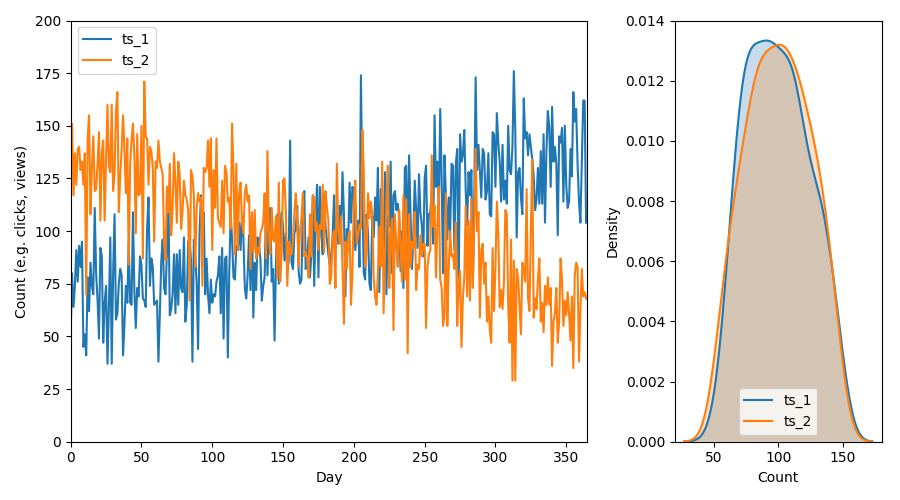

In [14]:
np.random.seed(13)
ts_1 = np.arange(0, 73, 0.2).astype('int') + \
    np.random.normal(loc=65.0, scale=20, size = ts_len).astype('int')
ts_2 = np.arange(73, 0, -0.2).astype('int') + \
    np.random.normal(loc=65.0, scale=20, size = ts_len).astype('int')

ts_list = [ts_1, ts_2]
percentiles = [1,25,50,75,99]
for i, ts in enumerate(ts_list):
    print("mean_{0} = {1:.2f}\t std_{0} = {2:.2f}\t skew_{0} = {3:.2f}\t kurt_{0} = {4:.2f}".format(
        i+1, np.mean(ts), np.std(ts), describe(ts).skewness, describe(ts).kurtosis))
for i, ts in enumerate(ts_list):    
    print("ts_" + str(i+1) + ":\t", *["p_" + str(p) + " = " + str(np.round(perc,1)) +"\t"
            for p, perc in zip(percentiles, np.percentile(a=ts, q=percentiles))])
for i, ts in enumerate(ts_list):    
    print("linear fit (y=mx+n) ts_" + str(i+1) + ":\t m = {0:.2f}\t n = {1:.2f}".format(
        *np.polyfit(range(len(ts)), ts, deg=1)))
plot_ts(ts_list)

mean_1 = 101.92	 std_1 = 21.69	 skew_1 = 0.11	 kurt_1 = -0.34
mean_2 = 101.15	 std_2 = 21.74	 skew_2 = -0.04	 kurt_2 = 0.30
ts_1:	 p_1 = 55.6	 p_25 = 87.0	 p_50 = 101.0	 p_75 = 116.0	 p_99 = 151.1	
ts_2:	 p_1 = 48.6	 p_25 = 87.0	 p_50 = 101.0	 p_75 = 116.0	 p_99 = 153.4	
linear fit (y = ax + b) ts_1:	 a = 0.00	 b = 101.34
linear fit (y = ax + b) ts_2:	 a = 0.01	 b = 99.01
quadratic fit (y = ax^2 + bx + c) ts_1:	 a = 0.00123	 b = -0.445	 c = 128.43
quadratic fit (y = ax^2 + bx + c) ts_2:	 a = -0.00099	 b = 0.373	 c = 77.19


<IPython.core.display.Javascript object>


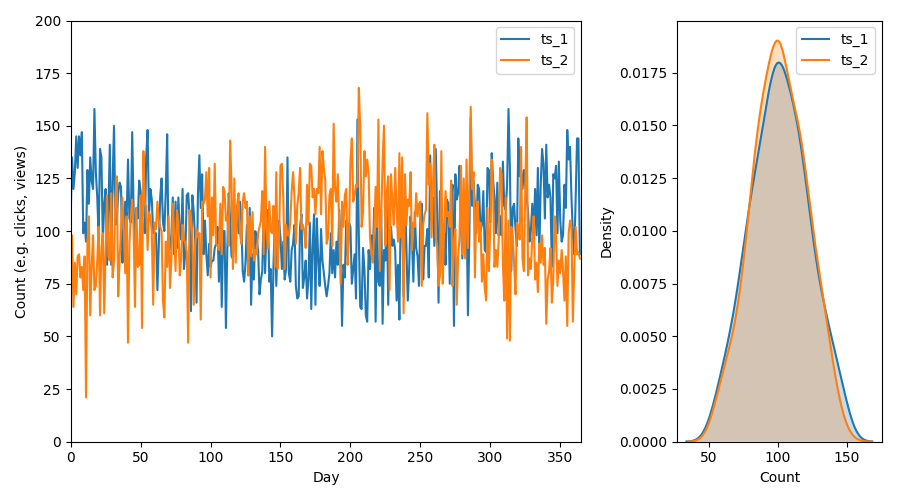

In [15]:
np.random.seed(13)
ts_1 = np.sqrt(np.power(np.arange(-36.5, 36.5, 0.2), 2)).astype('int') + \
    np.random.normal(loc=85.0, scale=19, size = ts_len).astype('int')
ts_2 = np.random.normal(loc=120.0, scale=20, size = ts_len).astype('int') - \
    np.sqrt(np.power(np.arange(-36.5, 36.5, 0.2), 2)).astype('int')

ts_list = [ts_1, ts_2]
percentiles = [1,25,50,75,99]
for i, ts in enumerate(ts_list):
    print("mean_{0} = {1:.2f}\t std_{0} = {2:.2f}\t skew_{0} = {3:.2f}\t kurt_{0} = {4:.2f}".format(
        i+1, np.mean(ts), np.std(ts), describe(ts).skewness, describe(ts).kurtosis))
for i, ts in enumerate(ts_list):    
    print("ts_" + str(i+1) + ":\t", *["p_" + str(p) + " = " + str(np.round(perc,1)) +"\t"
            for p, perc in zip(percentiles, np.percentile(a=ts, q=percentiles))])
for i, ts in enumerate(ts_list):    
    print("linear fit (y = ax + b) ts_" + str(i+1) + ":\t a = {0:.2f}\t b = {1:.2f}".format(
        *np.polyfit(range(len(ts)), ts, deg=1)))
for i, ts in enumerate(ts_list):    
    print("quadratic fit (y = ax^2 + bx + c) ts_" + str(i+1) + ":\t a = {0:.5f}\t b = {1:.3f}\t c = {2:.2f}".format(
        *np.polyfit(range(len(ts)), ts, deg=2)))
plot_ts(ts_list)

### AR models

Source: Dmitriy Sergeev

https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3

In [16]:
ads = pd.read_csv('./ads.csv', index_col=['Time'], parse_dates=['Time'])
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


<IPython.core.display.Javascript object>


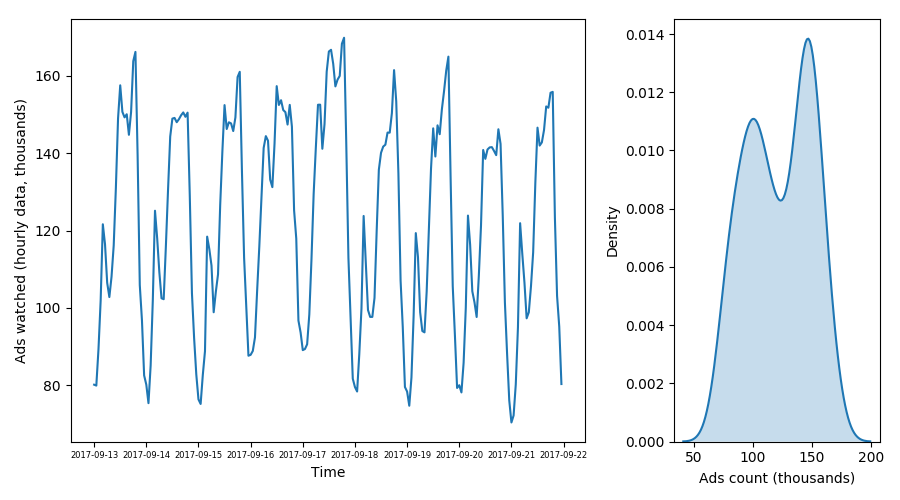

In [17]:
plt.figure(figsize=[9,5])
plt.xticks(fontsize=8)

gs = gridspec.GridSpec(1, 2, width_ratios=[5, 2])
ax1 = plt.subplot(gs[0])
ax1.plot(ads.Ads/1000)
ax1.set_xlabel('Time')
ax1.set_ylabel('Ads watched (hourly data, thousands)')
ax1.xaxis.set_tick_params(labelsize=6)

ax2 = plt.subplot(gs[1])
sns.kdeplot(ads.Ads.values/1000, ax=ax2, shade=True)
ax2.set_xlabel('Ads count (thousands)')
ax2.set_ylabel('Density')

plt.tick_params(axis='both', which='minor', labelsize=8)
plt.tight_layout()
plt.show()

In [18]:
from statsmodels.tsa.ar_model import AR

model = AR(ads.Ads[:72])
model_fit = model.fit(maxlag=24)
print('Lag: %s' % model_fit.k_ar)
print('Coefficients:\n %s' % model_fit.params)

Lag: 24
Coefficients:
 const      51107.439636
L1.Ads         0.491697
L2.Ads        -0.127249
L3.Ads        -0.171371
L4.Ads         0.217455
L5.Ads        -0.279549
L6.Ads         0.249175
L7.Ads        -0.178990
L8.Ads        -0.050557
L9.Ads         0.107179
L10.Ads       -0.119213
L11.Ads        0.071288
L12.Ads       -0.117067
L13.Ads        0.096390
L14.Ads       -0.095374
L15.Ads       -0.024403
L16.Ads        0.030442
L17.Ads       -0.068313
L18.Ads        0.008473
L19.Ads        0.009549
L20.Ads       -0.070488
L21.Ads        0.009211
L22.Ads       -0.051756
L23.Ads        0.188121
L24.Ads        0.445530
dtype: float64


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


<IPython.core.display.Javascript object>


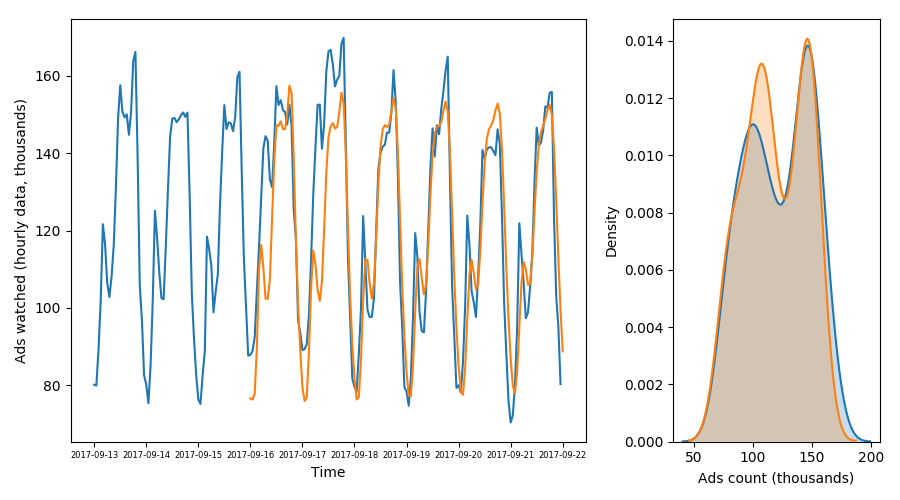

In [19]:
predictions = model_fit.predict(start=72, end=len(ads.Ads), dynamic=False)
plt.figure(figsize=[9,5])
plt.xticks(fontsize=8)

gs = gridspec.GridSpec(1, 2, width_ratios=[5, 2])
ax1 = plt.subplot(gs[0])
ax1.plot(ads.Ads/1000)
ax1.plot(predictions/1000)
ax1.set_xlabel('Time')
ax1.set_ylabel('Ads watched (hourly data, thousands)')
ax1.xaxis.set_tick_params(labelsize=6)

ax2 = plt.subplot(gs[1])
sns.kdeplot(ads.Ads.values/1000, ax=ax2, shade=True)
sns.kdeplot(predictions/1000, ax=ax2, shade=True)
ax2.set_xlabel('Ads count (thousands)')
ax2.set_ylabel('Density')

plt.tick_params(axis='both', which='minor', labelsize=8)
plt.tight_layout()
plt.show()

## Simple images

### Autoencoders
https://blog.keras.io/building-autoencoders-in-keras.html

https://blog.keras.io/img/ae/autoencoder_schema.jpg

In [20]:
nb_classes = 10
# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data(path='./mnist.npz')
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


<IPython.core.display.Javascript object>


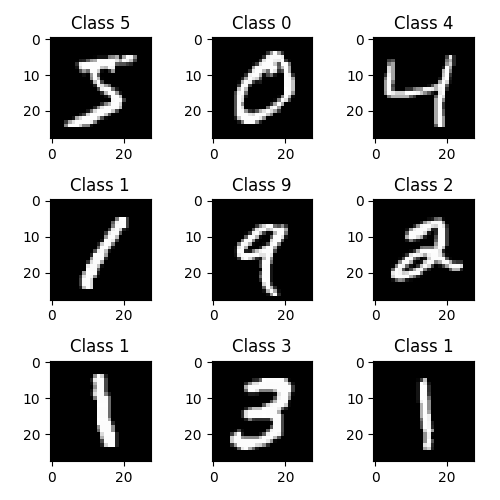

In [21]:
plt.figure(figsize=[5,5])
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))
plt.tight_layout()
plt.show()

In [22]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [23]:
from keras.models import Model
from keras.layers import Input, Dense

input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

encoder = Model(input_img, encoded)

history = autoencoder.fit(X_train, X_train, 
                          epochs=10, batch_size=64, shuffle=True,
                          validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 75us/step - loss: 0.1624 - val_loss: 0.1288
Epoch 2/10
60000/60000 [==============================] - 4s 69us/step - loss: 0.1203 - val_loss: 0.1229
Epoch 3/10
60000/60000 [==============================] - 4s 70us/step - loss: 0.1092 - val_loss: 0.1065
Epoch 4/10
60000/60000 [==============================] - 4s 70us/step - loss: 0.1031 - val_loss: 0.1004
Epoch 5/10
60000/60000 [==============================] - 4s 70us/step - loss: 0.0993 - val_loss: 0.0975
Epoch 6/10
60000/60000 [==============================] - 4s 70us/step - loss: 0.0965 - val_loss: 0.0942
Epoch 7/10
60000/60000 [==============================] - 4s 70us/step - loss: 0.0943 - val_loss: 0.0928
Epoch 8/10
60000/60000 [==============================] - 4s 67us/step - loss: 0.0926 - val_loss: 0.0912
Epoch 9/10
60000/60000 [==============================] - 4s 68us/step - loss: 0.0912 - val_loss: 0.0904
Epoch

In [42]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 784)               101136    
Total para

<IPython.core.display.Javascript object>


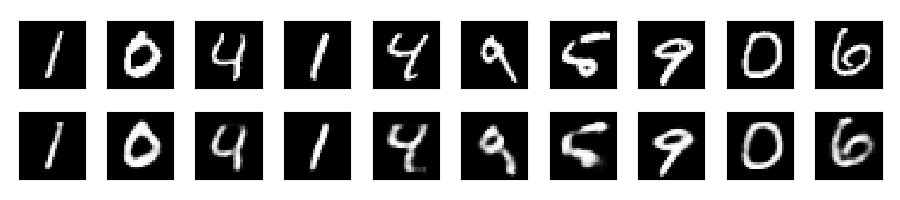

In [24]:
n=10
offset=2

decoded_imgs = autoencoder.predict(X_test[:n+offset]).reshape(n+offset, 28, 28)
scaler = sklearn.preprocessing.MinMaxScaler()
encoded_imgs = scaler.fit_transform(encoder.predict(X_test[:n+offset]))

plt.figure(figsize=(9, 2))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i + offset].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i + offset].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

In [41]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


In [25]:
encoded_imgs[:2]

array([[1.        , 0.        , 0.548615  , 0.57715416, 0.3791551 ,
        0.        , 0.        , 0.        , 0.462283  , 0.21547844,
        0.33319724, 0.3920849 , 0.5299697 , 1.        , 0.11931103,
        0.26608533, 0.43808857, 0.6270227 , 0.7605295 , 0.        ,
        0.8034024 , 0.99999994, 0.15967065, 0.5737695 , 0.08524603,
        0.531898  , 0.        , 0.        , 0.48121423, 0.        ,
        0.        , 0.59861326],
       [0.14702964, 0.        , 0.08906154, 0.9999999 , 0.        ,
        0.        , 0.        , 0.6993474 , 0.07511076, 0.66967565,
        0.35596746, 0.9870758 , 0.3471927 , 0.758365  , 0.87147886,
        1.        , 0.6078968 , 0.        , 0.3478847 , 0.        ,
        0.        , 0.14743094, 0.9999999 , 0.41639596, 0.7726583 ,
        0.7301077 , 0.        , 0.        , 0.4192555 , 0.        ,
        0.48112717, 0.56089365]], dtype=float32)

<IPython.core.display.Javascript object>


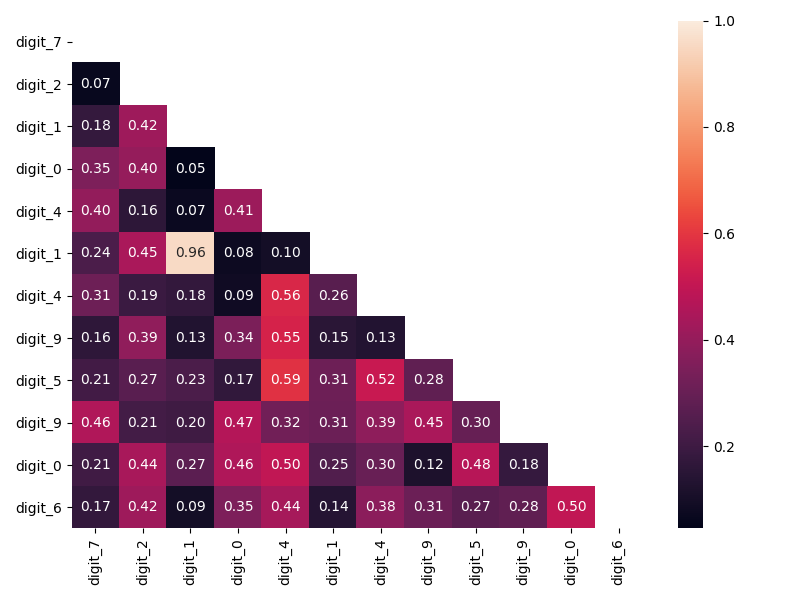

In [26]:
df_img_corr = pd.DataFrame(data=encoded_imgs.T,
                           columns=['digit_' + str(digit) for digit in y_test[:len(encoded_imgs)]])[offset:].corr()
mask = np.zeros_like(df_img_corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,6))
sns.heatmap(df_img_corr, mask=mask, annot=True, fmt=".2f")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


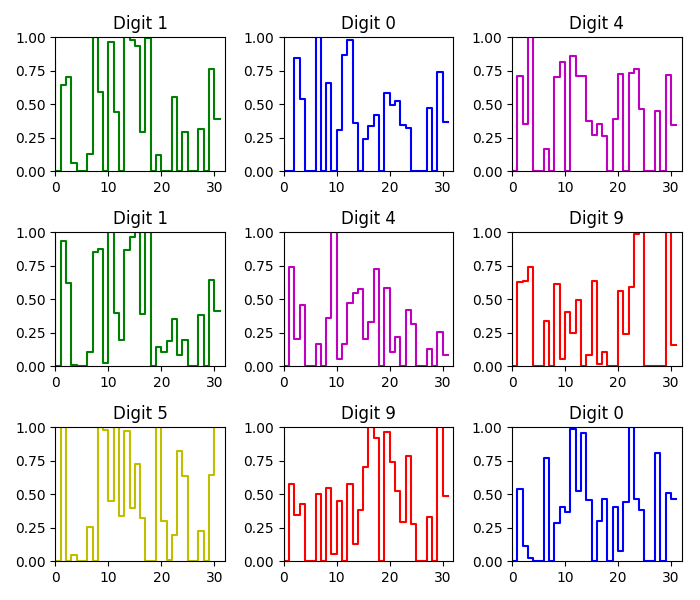

In [27]:
from matplotlib import colors as mcolors
colors = list(mcolors.BASE_COLORS.keys())
colors.remove('w')
plt.figure(figsize=[7,6])
for i in range(0, 9):
    ax = plt.subplot(3,3,i+1)
    enc_img = encoded_imgs[i+offset]
#     sns.kdeplot(enc_img, shade=True, color = colors[y_test[i+offset] % len(colors)])
    plt.step(range(len(enc_img)), enc_img, color = colors[y_test[i+offset] % len(colors)])
    ax.set_xlim(0, 32)
    ax.set_ylim(0, 1)
    plt.title("Digit {}".format(y_test[i+offset]))
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


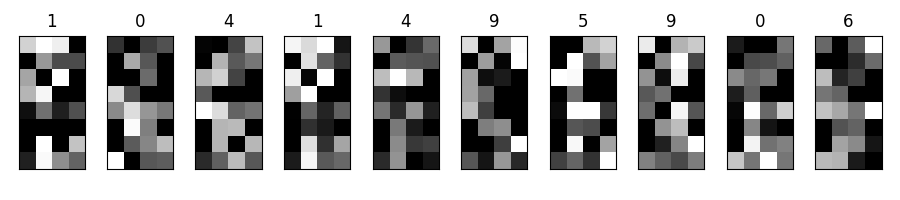

In [28]:
plt.figure(figsize=(9, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded_imgs[i+offset].reshape(4, 8).T)
    plt.gray()
    plt.title("{}".format(y_test[i+offset]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

In [29]:
Y_train = keras.utils.np_utils.to_categorical(y_train, nb_classes)
Y_test = keras.utils.np_utils.to_categorical(y_test, nb_classes)

np.random.seed(13)
model = Sequential()
model.add(Dense(128, input_dim=784))
model.add(Activation('relu')) 
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, batch_size=128, epochs=5, verbose=0,
                    validation_data=(X_test, Y_test))
print("\nValidation Accuracy = {:.3f}".format(history.history['val_acc'][-1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
__________

In [30]:
X_train_emb = encoder.predict(X_train)
X_test_emb = encoder.predict(X_test)
X_train_emb[:2]

array([[12.756969 ,  0.       ,  3.1943977,  5.9184237,  0.       ,
         0.       ,  0.       ,  9.925929 ,  0.       ,  3.979271 ,
        10.0538025, 12.264655 ,  6.8936157,  6.761577 ,  2.376011 ,
         3.036294 ,  9.312759 ,  7.802522 ,  9.205287 ,  0.       ,
         8.96561  ,  3.4530482,  1.2138221,  2.7333312,  6.2700768,
         8.201782 ,  0.       ,  0.       ,  3.4952805,  0.       ,
         4.64295  ,  6.868623 ],
       [ 1.4790659,  0.       ,  2.0879188,  5.9440103,  2.2710772,
         0.       ,  0.       , 12.479854 ,  0.       ,  3.9355712,
         2.8532248,  5.808654 ,  8.705958 ,  3.9752948,  5.5440083,
         2.3495126,  3.6297996, 10.52556  ,  3.6110275,  0.       ,
         9.080572 ,  3.5177186,  5.7211895,  7.507088 ,  2.5521355,
         1.3070015,  0.       ,  0.       ,  5.35407  ,  0.       ,
         6.100253 ,  3.4628196]], dtype=float32)

In [31]:
xgb_clf = xgb.XGBClassifier(n_estimators=500, objective='multi:softmax', num_class=10, max_depth=6, reg_lambda = 20,
                            nthread=8, tree_method='hist', max_bin=64, seed=13)
xgb_clf.fit(X_train_emb, y_train,
            eval_set=[(X_train_emb[:10000], y_train[:10000]), (X_test_emb, y_test)],
            early_stopping_rounds=20,
            eval_metric='merror', verbose=False)
print("Best score after {:d} rounds.".format(xgb_clf.best_iteration))
print("\nValidation Accuracy = {:.3f}".format(1- xgb_clf.best_score))

[08:24:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Best score after 257 rounds.

Validation Accuracy = 0.966


### ...or dimensionality reduction

In [32]:
import time
from sklearn.decomposition import PCA

start = time.time()
pca = PCA(n_components=16, random_state=13)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print('Time elapsed: {:.2f} seconds'.format(time.time()-start))

Time elapsed: 3.97 seconds


<IPython.core.display.Javascript object>


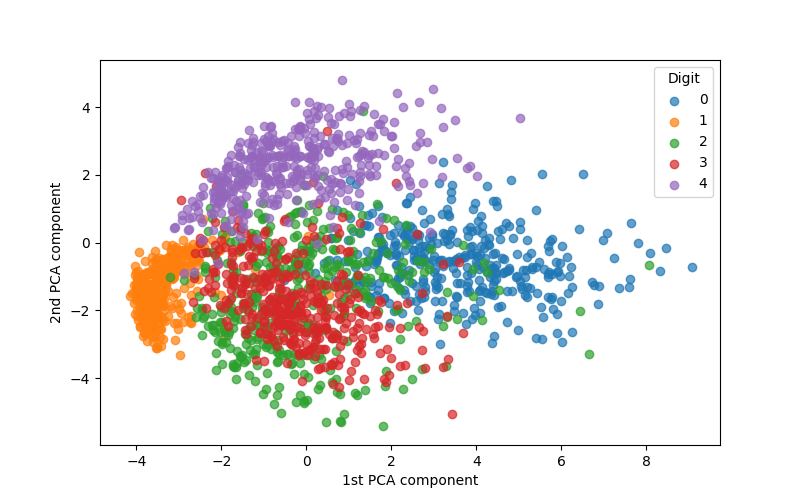

In [33]:
n_slice=slice(1000, 5000)
plt.figure(figsize=(8, 5))
for i in range(5):
    X_display = X_test_pca[n_slice][y_test[n_slice]==i]
    plt.scatter(X_display[:,0], X_display[:,1], marker='o', alpha=0.7, label = str(i))
plt.xlabel('1st PCA component')
plt.ylabel('2nd PCA component')
plt.legend(title='Digit')
plt.show()

In [34]:
X_train_pca[:3]

array([[ 0.48598477, -1.2261759 , -0.09613719, -2.1794322 , -0.10713168,
        -0.91160566,  0.91757673,  0.6266563 , -1.425504  ,  0.7776733 ,
         0.7742799 , -0.9964058 , -0.4431047 ,  2.942631  ,  0.86023444,
        -0.02158663],
       [ 3.9674804 , -1.1562992 ,  2.338586  , -1.8069068 , -3.2442706 ,
        -0.7135121 , -0.17663097, -0.4116503 ,  0.15854861,  0.5918583 ,
        -1.1226157 , -0.42071718, -1.2519213 ,  0.34728226, -0.9367331 ,
        -0.6413378 ],
       [-0.20338055,  1.5379106 , -0.7392759 ,  2.043274  , -1.202728  ,
        -0.00717196, -3.3688648 ,  1.4455184 , -0.44941878, -0.6996919 ,
         1.7670754 , -0.6230486 ,  0.7301012 ,  0.4251068 , -0.56841934,
        -0.7445544 ]], dtype=float32)

In [35]:
xgb_clf = xgb.XGBClassifier(n_estimators=500, objective='multi:softmax', num_class=10, max_depth=6, reg_lambda = 10,
                            nthread=8, tree_method='hist', max_bin=64, seed=13)
xgb_clf.fit(X_train_pca, y_train,
            eval_set=[(X_train_pca[:10000], y_train[:10000]), (X_test_pca, y_test)],
            early_stopping_rounds=20,
            eval_metric='merror', verbose=False)
print("Best score after {:d} rounds.".format(xgb_clf.best_iteration))
print("\nValidation Accuracy = {:.3f}".format(1- xgb_clf.best_score))

[08:24:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Best score after 414 rounds.

Validation Accuracy = 0.960


In [36]:
X_train_all = np.concatenate((X_train_emb, X_train_pca), axis = 1)
X_test_all = np.concatenate((X_test_emb, X_test_pca), axis = 1)

xgb_clf = xgb.XGBClassifier(n_estimators=500, objective='multi:softmax', num_class=10, max_depth=7, reg_lambda = 20,
                            nthread=8, tree_method='hist', max_bin=64, seed=13)
xgb_clf.fit(X_train_all, y_train,
            eval_set=[(X_train_all[:10000], y_train[:10000]), (X_test_all, y_test)],
            early_stopping_rounds=20,
            eval_metric='merror', verbose=False)
print("Best score after {:d} rounds.".format(xgb_clf.best_iteration))
print("\nValidation Accuracy = {:.3f}".format(1- xgb_clf.best_score))

[08:24:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Best score after 293 rounds.

Validation Accuracy = 0.973


In [37]:
feat_names = np.array(['encoder_' + str(i) for i in range(32)] + ['pca_comp_' + str(i) for i in range(16)])
feat_imp_idx = np.argsort(-xgb_clf.feature_importances_)
feat_imp = xgb_clf.feature_importances_
for i in feat_imp_idx[:12]:
    print("{0}\t{1:.3f}".format(feat_names[i], feat_imp[i]))

pca_comp_0	0.127
encoder_8	0.103
pca_comp_1	0.099
pca_comp_3	0.065
encoder_4	0.045
pca_comp_5	0.045
pca_comp_4	0.041
pca_comp_6	0.037
encoder_18	0.031
encoder_25	0.026
encoder_21	0.025
pca_comp_2	0.025


In [38]:
from sklearn.manifold import TSNE

start = time.time()
n_slice=slice(1000, 2000)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_train_tsne = tsne.fit_transform(X_train[n_slice])
print('Time elapsed: {:.2f} seconds'.format(time.time()-start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.015s...
[t-SNE] Computed neighbors for 1000 samples in 1.524s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.895871
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.741394
[t-SNE] KL divergence after 300 iterations: 1.185121
Time elapsed: 4.14 seconds


In [39]:
X_train_tsne[:2]

array([[ -5.8404584, -12.988854 ],
       [-12.852172 ,   4.652737 ]], dtype=float32)

<IPython.core.display.Javascript object>


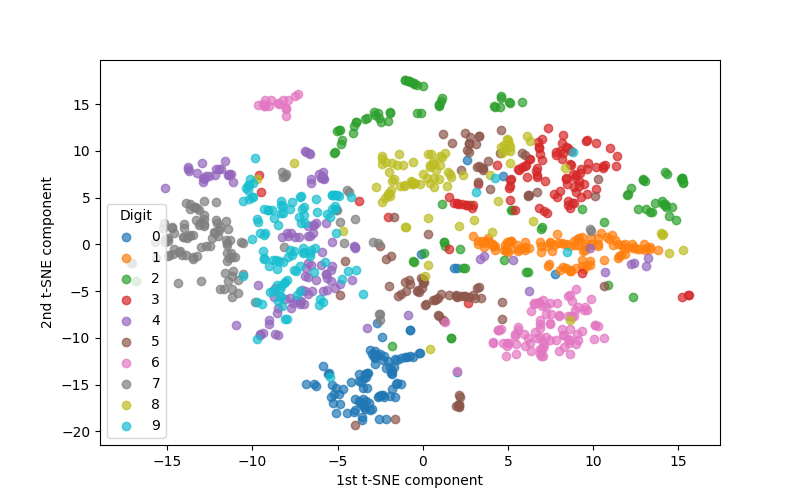

In [40]:
plt.figure(figsize=(8, 5))
for i in range(10):
    X_display = X_train_tsne[y_train[n_slice]==i]
    plt.scatter(X_display[:,0], X_display[:,1], marker='o', alpha=0.7, label = str(i))
plt.xlabel('1st t-SNE component')
plt.ylabel('2nd t-SNE component')
plt.legend(title='Digit')
plt.show()

#### Nice demo:
https://cs.stanford.edu/people/karpathy/tsnejs/

# And more...

## More complex images? pretrained networks!

Example: Use the output of intermediate layers from **VGG16**

<br>*Very Deep Convolutional Networks for Large-Scale Image Recognition* (https://arxiv.org/abs/1409.1556) - Karen Simonyan, Andrew Zisserman


```
conv_base = keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))```

https://www.researchgate.net/figure/A-schematic-of-the-VGG-16-Deep-Convolutional-Neural-Network-DCNN-architecture-trained_fig2_319952138

## Words, IDs, Labels, Bytes n-grams from sequence examples? Vector Space Models!

<br>https://upload.wikimedia.org/wikipedia/commons/f/ff/Vector_space_model.jpg
<br>http://mccormickml.com/assets/word2vec/training_data.png

#### Example: Use Word2Vec to recommenders and advertising
<br>http://mccormickml.com/2018/06/15/applying-word2vec-to-recommenders-and-advertising/